In [1]:
# IPython markdown libraries
from IPython.display import display, HTML, Markdown

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Toggle Code"></form>''')

# Project Description

> **DESCRIPTION:** Exploratory data analysis of credit risk data in order to create a model to predict credit risk score/rating for credit applicants

> **AUTHOR:** Neal Gilmore  
> **DATE:** 27-08-2020

# Table of Contents<a class="anchor" id="0.0"></a>

* [STEP 1: Environment Preparation](#1.0)  
    * [1.1 Import required libraries](#1.1)  
    * [1.2 Prepare for reproducability](#1.2)  
* [STEP 2: Data Preparation](#2.0)  
    * [2.1 Import data](#2.1)  
    * [2.2 Summary statistics](#2.2)  
* [STEP 3: Data Pre-processing](#3.0)  
    * [3.1 Pre-process (some) continuous variables](#3.1)  
        * [3.1.1 Convert employment length to float](#3.1.1)  
        * [3.1.2 Convert dates to proper date format](#3.1.2)  
        * [3.1.3 Calculate delta between earliest credit line and TODAY](#3.1.3)  
        * [3.1.4 Convert term to int](#3.1.4)  
        * [3.1.5 Clean issue date (issue_d) column](#3.1.5)  
    * [3.2 Pre-process (some) discrete variables](#3.2)  
        * [3.2.1 Convert discrete variables to dummy variables](#3.2.1)  
    * [3.3 Pre-process missing data](#3.3)  
* [STEP 4: Probability of Default (PD) Model Data Preparation](#4.0)  
    * [4.1 Define dependent variable - Default / Non-Default accounts](#4.1)  
* [STEP 5: Feature Engineering](#5.0)  
    * [5.1 Determine information value of categorical variables](#5.1)  
* [STEP 6: Prepare Data for Modeling](#6.0)  
    * [6.1 Split training and test data](#6.1)  
    * [6.2 Calculate Weight of Evidence (WoE) of discrete variables](#6.2)  
    * [6.3 Data visualization of Weight of Evidence (WoE) of categorical variables](#6.3)  
    * [6.4 Create dummy variables](#6.4)  
    

# STEP 1: Environment Preparation ([Top](#0.0))<a class="anchor" id="1.0"></a>

## 1.1 Import required libraries ([Top](#0.0))<a class="anchor" id="1.1"></a>

In [2]:
# System libraries
import os
import sys
import time
from datetime import datetime
import warnings
import random

# Standard libraries
import numpy as np
import pandas as pd
import dask
import dask.dataframe as dd
import matplotlib.pyplot as plt
import seaborn as sns

# Import machine learning libraries
from sklearn.model_selection import train_test_split

# Turn off Depreciation and Future warnings
warnings.simplefilter(action='ignore', category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

if not sys.warnoptions:
    warnings.simplefilter('ignore')

%matplotlib inline

print('>> Required libraries imported')

>> Required libraries imported


## 1.2 Prepare for reproducability ([Top](#0.0))<a class="anchor" id="1.2"></a>

In [3]:
# Set random seed to maintain reproducability
random_state = np.random.seed(42)

# Set the plotting style
plt.style.use('seaborn-whitegrid')

sns.set(style="whitegrid", palette="Blues", color_codes=True, font='sans-serif', font_scale=1.5)

# Force display of all columns in dataframes
pd.options.display.max_columns = None

# STEP 2: Data Preparation ([Top](#0.0))<a class="anchor" id="2.0"></a>

## 2.1 Import data ([Top](#0.0))<a class="anchor" id="2.1"></a>

In [4]:
# Import the dataset

# Set the data working directory
os.chdir(os.path.join(os.getcwd(), "..", "data", "raw"))

# Set the name of the file
filename = 'loan_data_2007_2014.csv'

# Read the data into memory as dask dataframe for speed
%time df_backup = dd.read_csv(filename)

# Create an initial copy of the data for processing
%time df = df_backup.copy()

# Convert dask dataframe to pandas dataframe
%time df = df.compute()

print('\n>> {} data successfully imported'.format(filename))

# Set the model working directory
os.chdir(os.path.join(os.getcwd(), "..", "..", "notebooks"))

CPU times: user 21.9 ms, sys: 4.84 ms, total: 26.8 ms
Wall time: 26.7 ms
CPU times: user 300 µs, sys: 17 µs, total: 317 µs
Wall time: 313 µs
CPU times: user 5.5 s, sys: 1.11 s, total: 6.61 s
Wall time: 3.65 s

>> loan_data_2007_2014.csv data successfully imported


## 2.2 Summary statistics ([Top](#0.0))<a class="anchor" id="2.2"></a>

In [5]:
# Describe the shape of the data
print("\nNumber of rows in the raw data: {}".format(df.shape[0]))
print("Number of columns in the raw data: {}\n".format(df.shape[1]))


Number of rows in the raw data: 466285
Number of columns in the raw data: 75



In [6]:
# Describe the df; Round values to 2 decimals
print(np.round(df.describe(), 2).T)

                                count         mean          std       min  \
Unnamed: 0                   466285.0    233142.00    134605.03      0.00   
id                           466285.0  13079729.91  10893711.62  54734.00   
member_id                    466285.0  14597660.62  11682367.44  70473.00   
loan_amnt                    466285.0     14317.28      8286.51    500.00   
funded_amnt                  466285.0     14291.80      8274.37    500.00   
funded_amnt_inv              466285.0     14222.33      8297.64      0.00   
int_rate                     466285.0        13.83         4.36      5.42   
installment                  466285.0       432.06       243.49     15.67   
annual_inc                   466281.0     73277.38     54963.57   1896.00   
dti                          466285.0        17.22         7.85      0.00   
delinq_2yrs                  466256.0         0.28         0.80      0.00   
inq_last_6mths               466256.0         0.80         1.09      0.00   

In [7]:
# Identify column datatypes
print(df.dtypes)

list(set(df.dtypes.tolist()))

Unnamed: 0            int64
id                    int64
member_id             int64
loan_amnt             int64
funded_amnt           int64
                     ...   
all_util            float64
total_rev_hi_lim    float64
inq_fi              float64
total_cu_tl         float64
inq_last_12m        float64
Length: 75, dtype: object


[dtype('int64'), dtype('float64'), dtype('O')]

In [8]:
# View the head of the data
print(df.head())

   Unnamed: 0       id  member_id  loan_amnt  funded_amnt  funded_amnt_inv  \
0           0  1077501    1296599       5000         5000           4975.0   
1           1  1077430    1314167       2500         2500           2500.0   
2           2  1077175    1313524       2400         2400           2400.0   
3           3  1076863    1277178      10000        10000          10000.0   
4           4  1075358    1311748       3000         3000           3000.0   

         term  int_rate  installment grade sub_grade  \
0   36 months     10.65       162.87     B        B2   
1   60 months     15.27        59.83     C        C4   
2   36 months     15.96        84.33     C        C5   
3   36 months     13.49       339.31     C        C1   
4   60 months     12.69        67.79     B        B5   

                  emp_title emp_length home_ownership  annual_inc  \
0                       NaN  10+ years           RENT     24000.0   
1                     Ryder   < 1 year           RENT   

In [9]:
# View the tail of the data
print(df.tail())

        Unnamed: 0       id  member_id  loan_amnt  funded_amnt  \
100358      466280  8598660    1440975      18400        18400   
100359      466281  9684700   11536848      22000        22000   
100360      466282  9584776   11436914      20700        20700   
100361      466283  9604874   11457002       2000         2000   
100362      466284  9199665   11061576      10000        10000   

        funded_amnt_inv        term  int_rate  installment grade sub_grade  \
100358          18400.0   60 months     14.47       432.64     C        C2   
100359          22000.0   60 months     19.97       582.50     D        D5   
100360          20700.0   60 months     16.99       514.34     D        D1   
100361           2000.0   36 months      7.90        62.59     A        A4   
100362           9975.0   36 months     19.20       367.58     D        D3   

                                    emp_title emp_length home_ownership  \
100358                     Financial Advisor     4 years   

In [10]:
# Identify all columns of the data
df.columns.values

array(['Unnamed: 0', 'id', 'member_id', 'loan_amnt', 'funded_amnt',
       'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade',
       'sub_grade', 'emp_title', 'emp_length', 'home_ownership',
       'annual_inc', 'verification_status', 'issue_d', 'loan_status',
       'pymnt_plan', 'url', 'desc', 'purpose', 'title', 'zip_code',
       'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status', 'out_prncp',
       'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv',
       'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee',
       'recoveries', 'collection_recovery_fee', 'last_pymnt_d',
       'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'policy_code', 'application_type', 'annual_inc_joint', 'dti_joint',
       'veri

In [11]:
# Provide info about the data (i.e. non-null values and datatypes)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 466285 entries, 0 to 100362
Data columns (total 75 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Unnamed: 0                   466285 non-null  int64  
 1   id                           466285 non-null  int64  
 2   member_id                    466285 non-null  int64  
 3   loan_amnt                    466285 non-null  int64  
 4   funded_amnt                  466285 non-null  int64  
 5   funded_amnt_inv              466285 non-null  float64
 6   term                         466285 non-null  object 
 7   int_rate                     466285 non-null  float64
 8   installment                  466285 non-null  float64
 9   grade                        466285 non-null  object 
 10  sub_grade                    466285 non-null  object 
 11  emp_title                    438697 non-null  object 
 12  emp_length                   445277 non-null  object 
 13 

# STEP 3: Data Pre-processing ([Top](#0.0))<a class="anchor" id="3.0"></a>¶

## 3.1 Pre-process (some) continuous variables ([Top](#0.0))<a class="anchor" id="3.0"></a>

**NOTE:** Not all continuous variables have been pre-processed for demo purposes

### 3.1.1 Convert employment length to float ([Top](#0.0))<a class="anchor" id="3.1.1"></a>

In [12]:
# Identify unique values of employment length
df['emp_length'].unique()

array(['10+ years', '< 1 year', '1 year', '3 years', '8 years', '9 years',
       '4 years', '5 years', '6 years', '2 years', '7 years', nan],
      dtype=object)

In [13]:
# Clean up the employment length column by creating a new variable as int
df['emp_length_int'] = df['emp_length'].str.replace('\+ years', '')
df['emp_length_int'] = df['emp_length_int'].str.replace('< 1 year', str(0))
df['emp_length_int'] = df['emp_length_int'].str.replace('n/a', str(0))
df['emp_length_int'] = df['emp_length_int'].str.replace(' years', '')
df['emp_length_int'] = df['emp_length_int'].str.replace(' year', '')

In [14]:
df['emp_length_int'].dtypes

dtype('O')

In [15]:
# Convert new column to int
df['emp_length_int'] = pd.to_numeric(df['emp_length_int'])

In [16]:
df['emp_length_int'].dtypes

dtype('float64')

### 3.1.2 Convert dates to proper date format ([Top](#0.0))<a class="anchor" id="3.1.2"></a>

In [17]:
# Review date format for earliest credit line
df['earliest_cr_line']

0         Jan-85
1         Apr-99
2         Nov-01
3         Feb-96
4         Jan-96
           ...  
100358    Apr-03
100359    Jun-97
100360    Dec-01
100361    Feb-03
100362    Feb-00
Name: earliest_cr_line, Length: 466285, dtype: object

In [18]:
# Convert earliest credit line to a date as a new variable
df['earliest_cr_line_date'] = pd.to_datetime(df['earliest_cr_line'], format = '%b-%y')

In [19]:
df['earliest_cr_line_date']

0        1985-01-01
1        1999-04-01
2        2001-11-01
3        1996-02-01
4        1996-01-01
            ...    
100358   2003-04-01
100359   1997-06-01
100360   2001-12-01
100361   2003-02-01
100362   2000-02-01
Name: earliest_cr_line_date, Length: 466285, dtype: datetime64[ns]

### 3.1.3 Calculate delta between earliest credit line and TODAY ([Top](#0.0))<a class="anchor" id="3.1.3"></a>

In [20]:
# Define today
now = datetime.now()
now - df['earliest_cr_line_date']

0        13057 days 11:57:24.744604
1         7854 days 11:57:24.744604
2         6909 days 11:57:24.744604
3         9009 days 11:57:24.744604
4         9040 days 11:57:24.744604
                    ...            
100358    6393 days 11:57:24.744604
100359    8523 days 11:57:24.744604
100360    6879 days 11:57:24.744604
100361    6452 days 11:57:24.744604
100362    7548 days 11:57:24.744604
Name: earliest_cr_line_date, Length: 466285, dtype: timedelta64[ns]

In [21]:
# Define months since earliest credit line
df['mths_since_earliest_cr_line'] = round(pd.to_numeric((now - df['earliest_cr_line_date']) / np.timedelta64(1, 'M')))

In [22]:
# Describe months since earliest credit line
df['mths_since_earliest_cr_line'].describe()

count    466256.000000
mean        273.482430
std          93.974829
min        -578.000000
25%         217.000000
50%         259.000000
75%         319.000000
max         621.000000
Name: mths_since_earliest_cr_line, dtype: float64

In [23]:
df.loc[: , ['earliest_cr_line', 'earliest_cr_line_date', 'mths_since_earliest_cr_line']][df['mths_since_earliest_cr_line'] < 0]

,earliest_cr_line,earliest_cr_line_date,mths_since_earliest_cr_line
1580,Sep-62,2062-09-01,-503.0
1770,Sep-68,2068-09-01,-575.0
2799,Sep-64,2064-09-01,-527.0
3282,Sep-67,2067-09-01,-563.0
3359,Feb-65,2065-02-01,-532.0
...,...,...,...
98081,Jan-68,2068-01-01,-567.0
98338,Jul-66,2066-07-01,-549.0
99178,Oct-67,2067-10-01,-564.0
99578,Sep-67,2067-09-01,-563.0


In [24]:
df['mths_since_earliest_cr_line'][df['mths_since_earliest_cr_line'] < 0] = df['mths_since_earliest_cr_line'].max()

In [25]:
min(df['mths_since_earliest_cr_line'])

107.0

### 3.1.4 Convert term to int ([Top](#0.0))<a class="anchor" id="3.1.4"></a>

In [26]:
# Investigate the term column
df['term']

0          36 months
1          60 months
2          36 months
3          36 months
4          60 months
             ...    
100358     60 months
100359     60 months
100360     60 months
100361     36 months
100362     36 months
Name: term, Length: 466285, dtype: object

In [27]:
# Describe the term column
df['term'].describe()

count         466285
unique             2
top        36 months
freq          337953
Name: term, dtype: object

In [28]:
# Identify unique values in the term column
df['term'].unique()

array([' 36 months', ' 60 months'], dtype=object)

In [29]:
# Create a new variable to store the int of term months
df['term_int'] = df['term'].str.replace(' months', '')

In [30]:
df['term_int'].dtypes

dtype('O')

In [31]:
# Convert the new variable to int
df['term_int'] = pd.to_numeric(df['term_int'])

In [32]:
df['term_int'].dtypes

dtype('int64')

### 3.1.5 Clean issue date (issue_d) column ([Top](#0.0))<a class="anchor" id="3.1.5"></a>

In [33]:
# Investigate the issue date column
df['issue_d']

0         Dec-11
1         Dec-11
2         Dec-11
3         Dec-11
4         Dec-11
           ...  
100358    Jan-14
100359    Jan-14
100360    Jan-14
100361    Jan-14
100362    Jan-14
Name: issue_d, Length: 466285, dtype: object

In [34]:
# Calculate months since issue date
# Assume we are now in October 2020
df['issue_d_date'] = pd.to_datetime(df['issue_d'], format = '%b-%y')
# Extracts the date and the time from a string variable that is in a given format

df['mths_since_issue_d'] = round(pd.to_numeric((now - df['issue_d_date']) / np.timedelta64(1, 'M')))
# We calculate the difference between two dates in months, turn it to numeric datatype and round it
# We save the result in a new variable.

df['mths_since_issue_d'].describe()
# Shows some descriptive statisics for the values of a column

count    466285.000000
mean         85.255187
std          14.340154
min          70.000000
25%          75.000000
50%          81.000000
75%          91.000000
max         160.000000
Name: mths_since_issue_d, dtype: float64

## 3.2 Pre-process (some) discrete variables ([Top](#0.0))<a class="anchor" id="3.2"></a>
**NOTE:** Not all discrete variables have been pre-processed for demo purposes

### 3.2.1 Convert discrete variables to dummy variables ([Top](#0.0))<a class="anchor" id="3.2.1"></a>

In [35]:
# EXAMPLE: Investigate grade column
df['grade']

0         B
1         C
2         C
3         C
4         B
         ..
100358    C
100359    D
100360    D
100361    A
100362    D
Name: grade, Length: 466285, dtype: object

In [36]:
# Convert grades variable to their own columns creating a space matrix
pd.get_dummies(df['grade'])

,A,B,C,D,E,F,G
0,0,1,0,0,0,0,0
1,0,0,1,0,0,0,0
2,0,0,1,0,0,0,0
3,0,0,1,0,0,0,0
4,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...
100358,0,0,1,0,0,0,0
100359,0,0,0,1,0,0,0
100360,0,0,0,1,0,0,0
100361,1,0,0,0,0,0,0


In [37]:
# Prepend 'grade:' to each of the new grade columns
pd.get_dummies(df['grade'], prefix = 'grade', prefix_sep = ': ')

,grade: A,grade: B,grade: C,grade: D,grade: E,grade: F,grade: G
0,0,1,0,0,0,0,0
1,0,0,1,0,0,0,0
2,0,0,1,0,0,0,0
3,0,0,1,0,0,0,0
4,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...
100358,0,0,1,0,0,0,0
100359,0,0,0,1,0,0,0
100360,0,0,0,1,0,0,0
100361,1,0,0,0,0,0,0


In [38]:
# Do the same for all discrete variables
df_dummies = [pd.get_dummies(df['grade'], prefix = 'grade', prefix_sep = ': '),
             pd.get_dummies(df['sub_grade'], prefix = 'sub_grade', prefix_sep = ': '),
             pd.get_dummies(df['home_ownership'], prefix = 'home_ownership', prefix_sep = ': '),
             pd.get_dummies(df['verification_status'], prefix = 'verification_status', prefix_sep = ': '),
             pd.get_dummies(df['loan_status'], prefix = 'loan_status', prefix_sep = ': '),
             pd.get_dummies(df['purpose'], prefix = 'purpose', prefix_sep = ': '),
             pd.get_dummies(df['addr_state'], prefix = 'addr_state', prefix_sep = ': '),
             pd.get_dummies(df['initial_list_status'], prefix = 'initial_list_status', prefix_sep = ': ')]

In [39]:
# Concatenate all the new discrete variable dummy columns
df_dummies = pd.concat(df_dummies, axis = 1)

In [40]:
# Concatenate the dummy variables to the original dataframe
df = pd.concat([df, df_dummies], axis = 1)

In [41]:
# Review the dataframe values
df.columns.values

array(['Unnamed: 0', 'id', 'member_id', 'loan_amnt', 'funded_amnt',
       'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade',
       'sub_grade', 'emp_title', 'emp_length', 'home_ownership',
       'annual_inc', 'verification_status', 'issue_d', 'loan_status',
       'pymnt_plan', 'url', 'desc', 'purpose', 'title', 'zip_code',
       'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status', 'out_prncp',
       'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv',
       'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee',
       'recoveries', 'collection_recovery_fee', 'last_pymnt_d',
       'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'policy_code', 'application_type', 'annual_inc_joint', 'dti_joint',
       'veri

## 3.3 Pre-process missing data ([Top](#0.0))<a class="anchor" id="3.3"></a>

In [42]:
df.isnull()

,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,emp_length_int,earliest_cr_line_date,mths_since_earliest_cr_line,term_int,issue_d_date,mths_since_issue_d,grade: A,grade: B,grade: C,grade: D,grade: E,grade: F,grade: G,sub_grade: A1,sub_grade: A2,sub_grade: A3,sub_grade: A4,sub_grade: A5,sub_grade: B1,sub_grade: B2,sub_grade: B3,sub_grade: B4,sub_grade: B5,sub_grade: C1,sub_grade: C2,sub_grade: C3,sub_grade: C4,sub_grade: C5,sub_grade: D1,sub_grade: D2,sub_grade: D3,sub_grade: D4,sub_grade: D5,sub_grade: E1,sub_grade: E2,sub_grade: E3,sub_grade: E4,sub_grade: E5,sub_grade: F1,sub_grade: F2,sub_grade: F3,sub_grade: F4,sub_grade: F5,sub_grade: G1,sub_grade: G2,sub_grade: G3,sub_grade: G4,sub_grade: G5,home_ownership: ANY,home_ownership: MORTGAGE,home_ownership: NONE,home_ownership: OTHER,home_ownership: OWN,home_ownership: RENT,verification_status: Not Verified,verification_status: Source Verified,verification_status: Verified,loan_status: Charged Off,loan_status: Current,loan_status: Default,loan_status: Does not meet the credit policy. Status:Charged Off,loan_status: Does not meet the credit policy. Status:Fully Paid,loan_status: Fully Paid,loan_status: In Grace Period,loan_status: Late (16-30 days),loan_status: Late (31-120 days),purpose: car,purpose: credit_card,purpose: debt_consolidation,purpose: educational,purpose: home_improvement,purpose: house,purpose: major_purchase,purpose: medical,purpose: moving,purpose: other,purpose: renewable_energy,purpose: small_business,purpose: vacation,purpose: wedding,addr_state: AK,addr_state: AL,addr_state: AR,addr_state: AZ,addr_state: CA,addr_state: CO,addr_state: CT,addr_state: DC,addr_state: DE,addr_state: FL,addr_state: GA,addr_state: HI,addr_state: IA,addr_state: ID,addr_state: IL,addr_state: IN,addr_state: KS,addr_state: KY,addr_state: LA,addr_state: MA,addr_state: MD,addr_state: ME,addr_state: MI,addr_state: MN,addr_state: MO,addr_state: MS,addr_state: MT,addr_state: NC,addr_state: NE,addr_state: NH,addr_state: NJ,addr_state: NM,addr_state: NV,addr_state: NY,addr_state: OH,addr_state: OK,addr_state: OR,addr_state: PA,addr_state: RI,addr_state: SC,addr_state: SD,addr_state: TN,addr_state: TX,addr_state: UT,addr_state: VA,addr_state: VT,addr_state: WA,addr_state: WI,addr_state: WV,addr_state: WY,initial_list_status: f,initial_list_status: w
0,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,True,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,Fal

In [43]:
pd.options.display.max_rows = None
df.isnull().sum()

Unnamed: 0                                                               0
id                                                                       0
member_id                                                                0
loan_amnt                                                                0
funded_amnt                                                              0
funded_amnt_inv                                                          0
term                                                                     0
int_rate                                                                 0
installment                                                              0
grade                                                                    0
sub_grade                                                                0
emp_title                                                            27588
emp_length                                                           21008
home_ownership           

In [44]:
pd.options.display.max_rows = 100

In [45]:
# Fill missing total_rev_hi_lim with funded_amnt
df['total_rev_hi_lim'].fillna(df['funded_amnt'], inplace = True)

In [46]:
df['total_rev_hi_lim'].isnull().sum()

0

In [47]:
# Fill missing annual_inc with the mean annual_inc value
df['annual_inc'].fillna(df['annual_inc'].mean(), inplace=True)

In [48]:
# Fill missing data in the following columns with 0
df['mths_since_earliest_cr_line'].fillna(0, inplace=True)
df['acc_now_delinq'].fillna(0, inplace=True)
df['total_acc'].fillna(0, inplace=True)
df['pub_rec'].fillna(0, inplace=True)
df['open_acc'].fillna(0, inplace=True)
df['inq_last_6mths'].fillna(0, inplace=True)
df['delinq_2yrs'].fillna(0, inplace=True)
df['emp_length_int'].fillna(0, inplace=True)

# STEP 4: Probability of Default (PD) Model Data Preparation ([Top](#0.0))<a class="anchor" id="4.0"></a>

## 4.1 Define dependent variable - Default / Non-Default accounts ([Top](#0.0))<a class="anchor" id="4.1"></a>

In [50]:
# Identify unique loan status values
df['loan_status'].unique()

array(['Fully Paid', 'Charged Off', 'Current', 'Default',
       'Late (31-120 days)', 'In Grace Period', 'Late (16-30 days)',
       'Does not meet the credit policy. Status:Fully Paid',
       'Does not meet the credit policy. Status:Charged Off'],
      dtype=object)

In [51]:
# Review distribution of loan status values
df['loan_status'].value_counts()

Current                                                224226
Fully Paid                                             184739
Charged Off                                             42475
Late (31-120 days)                                       6900
In Grace Period                                          3146
Does not meet the credit policy. Status:Fully Paid       1988
Late (16-30 days)                                        1218
Default                                                   832
Does not meet the credit policy. Status:Charged Off       761
Name: loan_status, dtype: int64

In [52]:
# Review distribution of loan status values as percentage of total count of loan statuses
df['loan_status'].value_counts() / df['loan_status'].count()

Current                                                0.480878
Fully Paid                                             0.396193
Charged Off                                            0.091092
Late (31-120 days)                                     0.014798
In Grace Period                                        0.006747
Does not meet the credit policy. Status:Fully Paid     0.004263
Late (16-30 days)                                      0.002612
Default                                                0.001784
Does not meet the credit policy. Status:Charged Off    0.001632
Name: loan_status, dtype: float64

In [53]:
# Define 'bad loans' as those that have been 'Charged Off', 
#'Does not meet the credit policy. Status:Charged Off', 
# or are 'Late (31-120 days)'
df['good_bad'] = np.where(df['loan_status'].isin(['Charged Off', 
                                                  'Does not meet the credit policy. Status:Charged Off', 
                                                 'Late (31-120 days)']),0, 1)

In [54]:
# 1 = bad loan, 0 = good loan
df['good_bad']

0         1
1         0
2         1
3         1
4         1
         ..
100358    1
100359    0
100360    1
100361    1
100362    1
Name: good_bad, Length: 466285, dtype: int64

# STEP 5: Feature Engineering ([Top](#0.0))<a class="anchor" id="5.0"></a>

## 5.1 Determine information value of categorical variables ([Top](#0.0))<a class="anchor" id="5.1"></a>

**Weight of Evidence:** (The extent to which a categorically independent variable explains the difference of a categorical outcome variable)

$$
\text{WoE}_{i} = \text{ln} \left( \frac{\%(y = 1)_{i}}{\%(y = 0)_{i}} \right) = \text{ln} \left( \frac{\%\text{good}_{i}}{\%\text{bad}_{i}} \right)
$$

**Information Value:** How much information the original independent variable brings with respect to explaining the dependent variable (Range of 0->1)

$$
\text{Information Value} = \sum_{i=1}^{k} \left[(\% \text{good} - \% \text{bad}) X \text{ln} \left( \frac{\%\text{good}}{\%\text{bad}} \right) \right]
$$

| Information Value Range: 0 - 1 | Predictive Powers |
|--- |----------| 
| IV < 0.02 | No predictive power |
| 0.02 < IV < 0.1 | Weak predictive power |
| 0.1 < IV < 0.3 | Medium predictive power |
| 0.3 < IV < 0.5 | Strong predictive power |
| 0.5 < IV | Suspiciously high, likely too good to be true |

**Example:** Education Variable

| Variable Categories | Good | Bad | Proportion Good | Proportion Bad | Weight of Evidence | % Good - % Bad |  |
| ---------- | ---- | --- | ---------- | ---------- | ---------- | ---------- | --------- |
| Higher Education | 4,000 | 600 | 25% | 15% | 0.51 | 0.1 | 0.0511 |
| No Higher Education | 12,000 | 3,400 | 75% | 85% | -0.13 | -0.1 | 0.0125 |
|  | 16,000 | 4,000 | 100% | 100% |  | **Information Value** | **0.0636** |

# STEP 6: Prepare Data for Modeling ([Top](#0.0))<a class="anchor" id="6.0"></a>

## 6.1 Split training and test data ([Top](#0.0))<a class="anchor" id="6.1"></a>

In [55]:
# Create the Training and Test set from data
X_train, X_test, y_train, y_test = train_test_split(df.drop('good_bad', axis = 1), df['good_bad'], 
                                                    test_size = 0.20,
                                                    random_state = random_state)

In [56]:
X_train.shape

(373028, 207)

In [57]:
y_train.shape

(373028,)

In [58]:
X_test.shape

(93257, 207)

In [59]:
y_test.shape

(93257,)

In [60]:
df_inputs_preproc = X_train
df_targets_preproc = y_train

## 6.2 Calculate Weight of Evidence (WoE) of discrete variables ([Top](#0.0))<a class="anchor" id="6.2"></a>

In [64]:
def woe_discrete(df, discrete_var_name, good_bad_var_df):
    df = pd.concat([df[discrete_var_name], good_bad_var_df], axis = 1)
    df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(), 
                df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].mean()],
               axis = 1)
    # Keep only required columns
    df = df.iloc[: , [0, 1, 3]]
    # Rename columns
    df.columns = [df.columns.values[0], 'n_obs', 'prop_good']
    # Calculate proportion of observations from total number of observations
    df['prop_n_obs'] = df['n_obs'] / df['n_obs'].sum()
    # CaLculate the number of good and bad borrowers
    df['n_good'] = df['prop_good'] * df['n_obs']
    df['n_bad'] = (1 - df['prop_good']) * df['n_obs']
    # Calculate the proportion of good and bad borrowers from the total number of borrowers
    df['prop_n_good'] = df['n_good'] / df['n_good'].sum()
    df['prop_n_bad'] = df['n_bad'] / df['n_bad'].sum()
    # Calculate the weight of evidence
    df['WoE'] = np.log(df['prop_n_good'] / df['prop_n_bad'])
    # Sort by weight of evidence and reset the index
    df = df.sort_values(['WoE'])
    df = df.reset_index(drop = True)
    # Calculate the differences in proportion of good loans and weight of evidence
    df['diff_prop_good'] = df['prop_good'].diff().abs()
    df['diff_WoE'] = df['WoE'].diff().abs()
    # Calculate the information value
    df['IV'] = (df['prop_n_good'] - df['prop_n_bad']) * df['WoE']
    df['IV'] = df['IV'].sum()
    
    return df

In [74]:
# Identify unique values in grade variable
df_inputs_preproc['grade'].unique()

array(['A', 'C', 'D', 'B', 'E', 'F', 'G'], dtype=object)

In [65]:
# Calculate weight of evidence for each of the grade values
df_temp = woe_discrete(df_inputs_preproc, 'grade', df_targets_preproc)

In [66]:
df_temp

,grade,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,G,2654,0.731349,0.007115,1941.0,713.0,0.005830,0.017772,-1.114542,NaN,NaN,0.285803
1,F,10530,0.757455,0.028228,7976.0,2554.0,0.023958,0.063661,-0.977243,0.026106,0.137299,0.285803
2,E,28612,0.808996,0.076702,23147.0,5465.0,0.069530,0.136220,-0.672518,0.051541,0.304725,0.285803
3,D,61498,0.848873,0.164862,52204.0,9294.0,0.156812,0.231661,-0.390229,0.039877,0.282289,0.285803
4,C,100245,0.887845,0.268733,89002.0,11243.0,0.267346,0.280241,-0.047106,0.038972,0.343123,0.285803
5,B,109730,0.922118,0.294160,101184.0,8546.0,0.303939,0.213016,0.355458,0.034273,0.402564,0.285803
6,A,59759,0.961445,0.160200,57455.0,2304.0,0.172585,0.057429,1.100336,0.039327,0.744878,0.285803


## 6.3 Data visualization of Weight of Evidence (WoE) of categorical variables ([Top](#0.0))<a class="anchor" id="6.3"></a>

In [67]:
def plot_by_woe(df_WoE, rotation_of_x_axis_labels = 0):
    x = np.array(df_WoE.iloc[:, 0].apply(str))
    y = df_WoE['WoE']
    
    plt.figure(figsize = (18, 6))
    plt.plot(x, 
             y, 
             marker = 'o', 
             linestyle = '--', 
             #markeredgecolor = 'white',
             color = 'k')
    plt.xlabel(df_WoE.columns[0])
    plt.ylabel('Weight of Evidence (WoE)')
    plt.title(str('Weight of Evidence (WoE) by ' + df_WoE.columns[0]))
    plt.xticks(rotation = rotation_of_x_axis_labels)

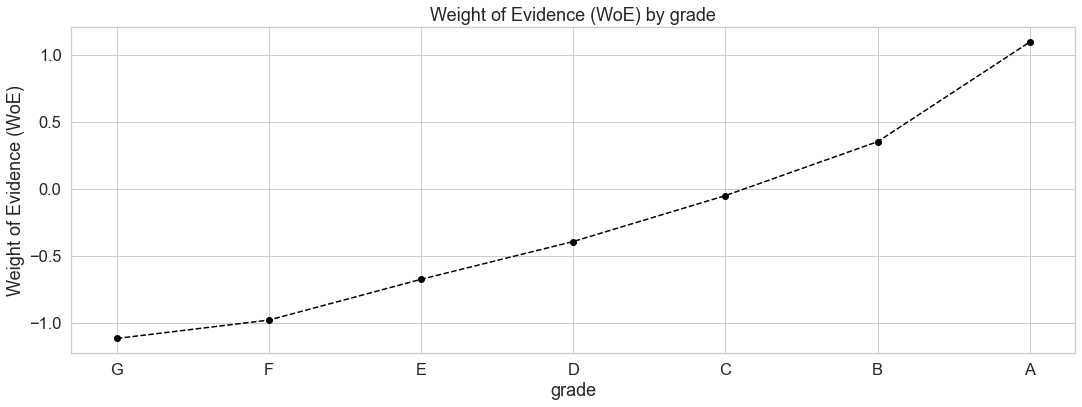

In [68]:
# Visualize weight of evidence of grade
plot_by_woe(df_temp)

## 6.4 Create dummy variables ([Top](#0.0))<a class="anchor" id="6.4"></a>

In [73]:
# Identify unique values of home ownership
df_inputs_preproc['home_ownership'].unique()

array(['MORTGAGE', 'RENT', 'OWN', 'NONE', 'OTHER', 'ANY'], dtype=object)

In [69]:
# Calculate weight of evidence of home ownership values
df_temp = woe_discrete(df_inputs_preproc, 'home_ownership', df_targets_preproc)

In [70]:
df_temp

,home_ownership,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,OTHER,137,0.795620,0.000367,109.0,28.0,0.000327,0.000698,-0.756876,NaN,NaN,inf
1,NONE,40,0.850000,0.000107,34.0,6.0,0.000102,0.000150,-0.381418,0.054380,0.375458,inf
2,RENT,150599,0.876062,0.403720,131934.0,18665.0,0.396306,0.465241,-0.160367,0.026062,0.221051,inf
3,OWN,33295,0.894338,0.089256,29777.0,3518.0,0.089445,0.087689,0.019824,0.018277,0.180192,inf
4,MORTGAGE,188956,0.905258,0.506546,171054.0,17902.0,0.513816,0.446222,0.141048,0.010920,0.121223,inf
5,ANY,1,1.000000,0.000003,1.0,0.0,0.000003,0.000000,inf,0.094742,inf,inf


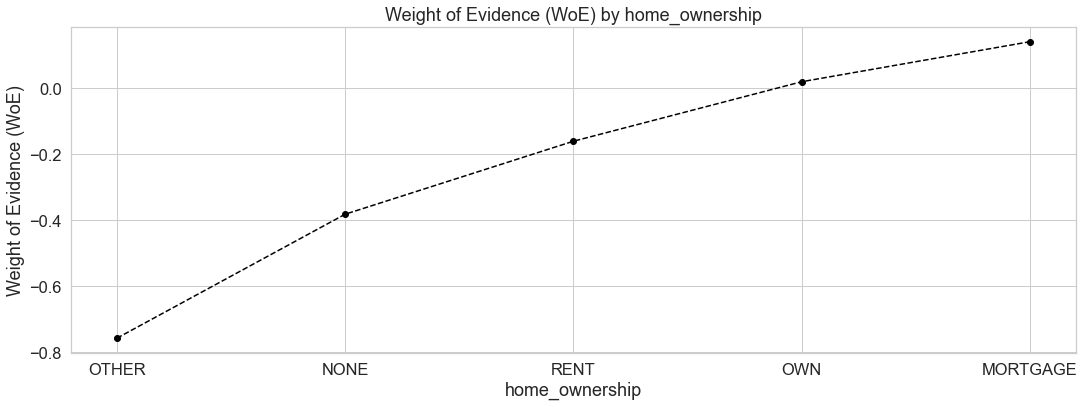

In [71]:
# Visualize the weight of evidence of home ownership
plot_by_woe(df_temp)

In [72]:
# Combine underrepresented categories (Other, None, Any) into Rent as they are very 
# underrepresented in the data (see df_temp above)
df_inputs_preproc['home ownership: RENT_OTHER_NONE_ANY'] = sum([df_inputs_preproc['home_ownership: RENT'],
                                                              df_inputs_preproc['home_ownership: OTHER'],
                                                              df_inputs_preproc['home_ownership: NONE'],
                                                              df_inputs_preproc['home_ownership: ANY']])

In [ ]:
# List of reference categories
# grade: A
# grade: B
# grade: C
# grade: D
# grade: E
# grade: F
# grade: G * Drop from dummies
# home ownership: RENT_OTHER_NONE_ANY * Drop from dummies
# home ownership: OWN
# home ownership: MORTGAGE
# addr_state: ND_NE_IA_NV_FL_AL_HI * Drop from dummies
# addr_state: NY
# addr_state: MO_MD_TN_NC
# addr_state: CA
# addr_state: LA_UT
# addr_state: KY_NJ_AZ_AR_PA_MI_MN_OH
# addr_state: SD_MA_IN_RI
# addr_state: DE_OR_WA_GA_WI_MT
# addr_state: TX
# addr_state: IL_CT_KS
# addr_state: SC_CO_VT_AK_MS
# addr_state: WV_NH_WY_DC_ME_ID

In [72]:
# Identify unique values for address state variable
df_inputs_preproc['addr_state'].unique()

array(['SC', 'NJ', 'GA', 'MA', 'CA', 'IL', 'NC', 'NY', 'TX', 'CT', 'FL',
       'VA', 'UT', 'AZ', 'MD', 'WI', 'MI', 'CO', 'TN', 'IN', 'AL', 'NV',
       'MT', 'RI', 'OR', 'MN', 'KS', 'AK', 'PA', 'OH', 'WA', 'KY', 'OK',
       'MO', 'NM', 'HI', 'WV', 'LA', 'VT', 'AR', 'DC', 'SD', 'NH', 'WY',
       'MS', 'DE', 'IA', 'NE', 'ID', 'ME'], dtype=object)

In [75]:
# Calculate weight of evidence of address state values
df_temp = woe_discrete(df_inputs_preproc, 'addr_state', df_targets_preproc)

In [76]:
df_temp

,addr_state,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,NE,13,0.461538,0.000035,6.0,7.0,0.000018,0.000174,-2.270170,NaN,NaN,inf
1,IA,13,0.769231,0.000035,10.0,3.0,0.000030,0.000075,-0.912046,0.307692,1.358123,inf
2,NV,5221,0.867458,0.013996,4529.0,692.0,0.013604,0.017249,-0.237349,0.098228,0.674698,inf
3,FL,25211,0.877672,0.067585,22127.0,3084.0,0.066466,0.076871,-0.145448,0.010214,0.091901,inf
4,AL,4671,0.878185,0.012522,4102.0,569.0,0.012322,0.014183,-0.140670,0.000512,0.004778,inf
5,HI,2001,0.878561,0.005364,1758.0,243.0,0.005281,0.006057,-0.137149,0.000376,0.003521,inf
6,NM,2075,0.884819,0.005563,1836.0,239.0,0.005515,0.005957,-0.077138,0.006259,0.060010,inf
7,VA,11366,0.885184,0.030470,10061.0,1305.0,0.030221,0.032528,-0.073556,0.000365,0.003583,inf
8,OK,3284,0.885505,0.008804,2908.0,376.0,0.008735,0.009372,-0.070387,0.000322,0.003168,inf
9,NY,32211,0.885971,0.086350,28538.0,3673.0,0.085723,0.091553,-0.065791,0.000465,0.004596,inf


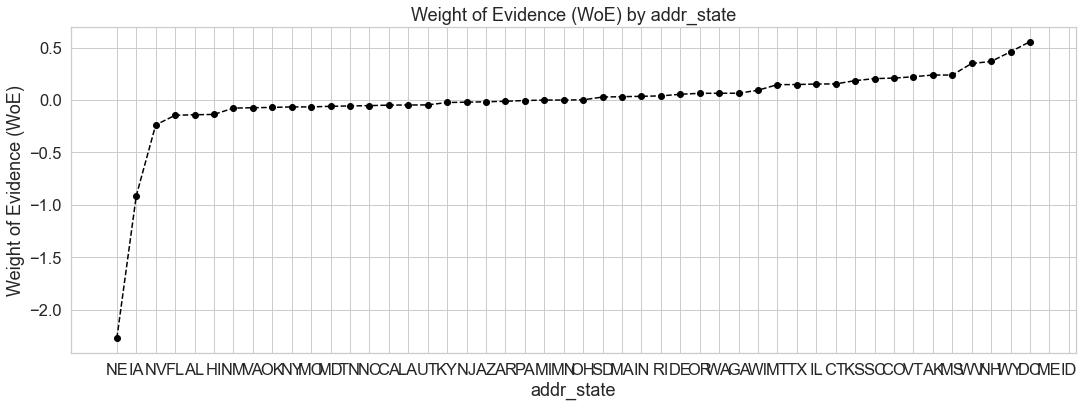

In [77]:
# Visualize the weight of evidence of address state
plot_by_woe(df_temp)

In [78]:
# Account for the fact that ND has no applicants
if ['addr_state: ND'] in df_inputs_preproc.columns.values:
    pass
else:
    df_inputs_preproc['addr_state'] = 0

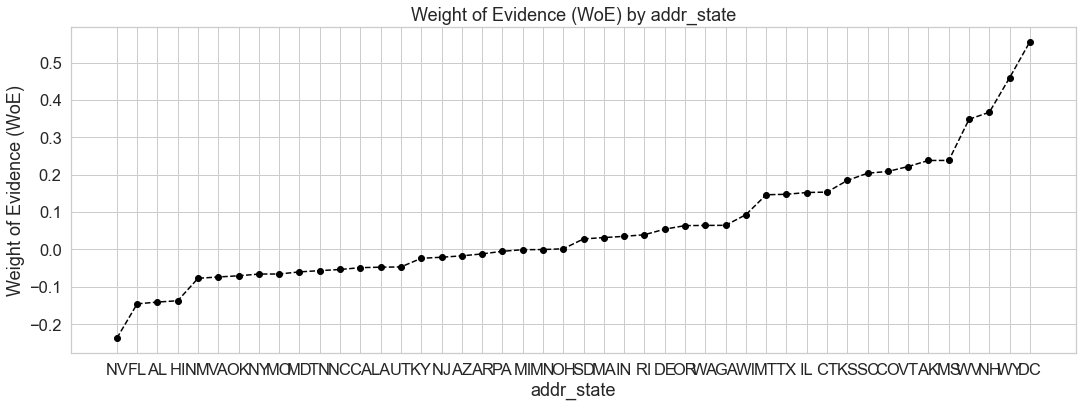

In [80]:
# Lowest and highest weight of evidence states have very few observations so it makes
# no sense to keep them as separate categories

# Visualize the weight of evidence of address state without the top and bottom 2 states
plot_by_woe(df_temp.iloc[2: -2, :])

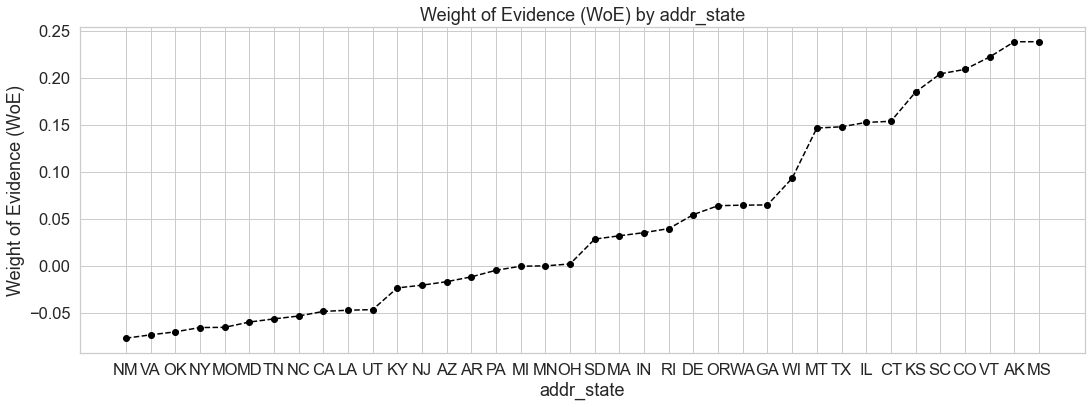

In [81]:
# NOTES
# Given the few n_obs of the first three states (plus the 2 previously dropped), it makes sense to group them
# The last 4 states can also be grouped (with the previously dropped top 2 states) due to their similarly few observations
# Visualize the weight of evidence of address state without the these states
plot_by_woe(df_temp.iloc[6: -6, :])

In [ ]:
# Given the number of borrowers from both NY and California they should be their own groups
# Groups:
#1: NM-OK
#2: NY
#3: MO-NC
#4: CA
#5: LA-UT
#6: KY-OH
#7: SD-RI
#8: DE-MT
#9: TX
#10: IL-KS
#11: SC-MS

In [ ]:
# Group the address states based on number of observations and similar weights of evidence
# Group 1: Group the first 7 states
df_inputs_preproc['addr_state: ND_NE_IA_NV_FL_AL_HI'] = sum([df_inputs_preproc['addr_state: ND'],
                                                             df_inputs_preproc['addr_state: NE'],
                                                             df_inputs_preproc['addr_state: IA'],
                                                             df_inputs_preproc['addr_state: NV'],
                                                             df_inputs_preproc['addr_state: FL'],
                                                             df_inputs_preproc['addr_state: AL'],
                                                             df_inputs_preproc['addr_state: HI']])

# Group 3: MO-NC
df_inputs_preproc['addr_state: MO_MD_TN_NC'] = sum([df_inputs_preproc['addr_state: MO'],
                                                    df_inputs_preproc['addr_state: MD'],
                                                    df_inputs_preproc['addr_state: TN'],
                                                    df_inputs_preproc['addr_state: NC']])

# Group 5: LA-UT
df_inputs_preproc['addr_state: LA_UT'] = sum([df_inputs_preproc['addr_state: LA'],
                                              df_inputs_preproc['addr_state: UT']])

# Group 6: KY-OH
df_inputs_preproc['addr_state: KY_NJ_AZ_AR_PA_MI_MN_OH'] = sum([df_inputs_preproc['addr_state: KY'],
                                                                df_inputs_preproc['addr_state: NJ'],
                                                                df_inputs_preproc['addr_state: AZ'],
                                                                df_inputs_preproc['addr_state: AR'],
                                                                df_inputs_preproc['addr_state: PA'],
                                                                df_inputs_preproc['addr_state: MI'],
                                                                df_inputs_preproc['addr_state: MN'],
                                                                df_inputs_preproc['addr_state: OH']])

# Group 7: SD-RI
df_inputs_preproc['addr_state: SD_MA_IN_RI'] = sum([df_inputs_preproc['addr_state: SD'],
                                                    df_inputs_preproc['addr_state: MA'],
                                                    df_inputs_preproc['addr_state: IN'],
                                                    df_inputs_preproc['addr_state: RI']])

# Group 8: DE-MT
df_inputs_preproc['addr_state: DE_OR_WA_GA_WI_MT'] = sum([df_inputs_preproc['addr_state: DE'],
                                                          df_inputs_preproc['addr_state: OR'],
                                                          df_inputs_preproc['addr_state: WA'],
                                                          df_inputs_preproc['addr_state: GA'],
                                                          df_inputs_preproc['addr_state: WI'],
                                                          df_inputs_preproc['addr_state: MT']])

# Group 10: IL-KS
df_inputs_preproc['addr_state: IL_CT_KS'] = sum([df_inputs_preproc['addr_state: IL'],
                                                 df_inputs_preproc['addr_state: CT'],
                                                 df_inputs_preproc['addr_state: KS']])

# Group 11: SC-MS
df_inputs_preproc['addr_state: SC_CO_VT_AK_MS'] = sum([df_inputs_preproc['addr_state: SC'],
                                                       df_inputs_preproc['addr_state: CO'],
                                                       df_inputs_preproc['addr_state: VT'],
                                                       df_inputs_preproc['addr_state: AK'],
                                                       df_inputs_preproc['addr_state: MS']])

# Group 12: WV-ID
df_inputs_preproc['addr_state: WV_NH_WY_DC_ME_ID'] = sum([df_inputs_preproc['addr_state: WV'],
                                                          df_inputs_preproc['addr_state: NH'],
                                                          df_inputs_preproc['addr_state: WY'],
                                                          df_inputs_preproc['addr_state: DC'],
                                                          df_inputs_preproc['addr_state: ME'],
                                                          df_inputs_preproc['addr_state: ID']])